# Deep Learning project: Military Aicraft Detection

Authors: 
* Giacomo Victor Massari 5112625
* Martina Sangiorgi 5105825

Dataset Link:
[Military Aircraft Detection Dataset](https://www.kaggle.com/datasets/a2015003713/militaryaircraftdetectiondataset)

In this project We are going to carry out an **Image Classification** task on a dataset consisting of 40 modern aircraft types. 
Since We are not interested in Bounding-Box Modelling, we are going to consider for our analysis only the '*Crop*' subfolders, which are already divided in classes per aircraft. These ones indeed contain **real images** focused only on the aircraft; We won't use '*dataset*' folder since its images are Real High Resolution pictures, where however the Aircraft is not easily recognizable. This could make the analysis over complicated.


---

We start by importing all the necessary packages for the analysis and the dataset from the [GitHub Repository](https://github.com/gvector/Aircraft_Project).

Then We mount the Google Drive in order to save models' weights for the Test phase.


# Enviroment Setting

In [1]:
!pip install d2l==1.0.0a1.post0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.9/120.9 KB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.8 MB/s eta 0:00:00


In [2]:
!pip install gitpython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 4.5 MB/s eta 0:00:00


In [3]:
from d2l import torch as d2l
import shutil
import torch
from torch import nn
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from tqdm import tqdm
import git
from git import Repo
import os
import pandas as pd
import requests
import re, sys, json, cv2, random
import PIL
from PIL import Image 
import numpy as np
import os 
import torchvision
import torchvision.transforms as tf
from google.colab import drive
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision import datasets
import torchvision.datasets as datasets
import torch.utils.data as data
from torchvision.datasets import ImageFolder
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [4]:
try:
  Repo.clone_from("https://github.com/gvector/Aircraft_Project.git", "/content/Aircfraft_new")
except:
  print('Repository already created')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Preparation

Now We clean the dataset from the useless folders, which We decided to not consider.

Navigate through files

In [6]:
%pwd

'/content'

In [7]:
%cd /content/Aircfraft_new

/content/Aircfraft_new


Let's remove the following folders: 'annotated_samples', 'README' and 'dataset'.

In [8]:
!rm -rf '/content/Aircfraft_new/annotated_samples'

In [9]:
!rm -rf '/content/Aircfraft_new/README.md'

In [10]:
!rm -rf '/content/Aircfraft_new/dataset'

## Work on Crop folders 

Firstly We check the content of the crop folders to see all the subfolders' names and other possible unwanted files (as '.DS_Store')

In [11]:
path = '/content/Aircfraft_new/crop'

for fil in os.listdir(path):
  fil_path = '/content/Aircfraft_new/crop' + '/' + fil

  print(fil_path)

/content/Aircfraft_new/crop/.DS_Store
/content/Aircfraft_new/crop/Tu95
/content/Aircfraft_new/crop/A400M
/content/Aircfraft_new/crop/YF23
/content/Aircfraft_new/crop/US2
/content/Aircfraft_new/crop/Su57
/content/Aircfraft_new/crop/F22
/content/Aircfraft_new/crop/Tu160
/content/Aircfraft_new/crop/Tornado
/content/Aircfraft_new/crop/Mirage2000
/content/Aircfraft_new/crop/Su34
/content/Aircfraft_new/crop/V22
/content/Aircfraft_new/crop/B1
/content/Aircfraft_new/crop/F15
/content/Aircfraft_new/crop/F16
/content/Aircfraft_new/crop/AG600
/content/Aircfraft_new/crop/JAS39
/content/Aircfraft_new/crop/AV8B
/content/Aircfraft_new/crop/RQ4
/content/Aircfraft_new/crop/XB70
/content/Aircfraft_new/crop/B52
/content/Aircfraft_new/crop/U2
/content/Aircfraft_new/crop/C130
/content/Aircfraft_new/crop/MQ9
/content/Aircfraft_new/crop/C17
/content/Aircfraft_new/crop/F35
/content/Aircfraft_new/crop/F18
/content/Aircfraft_new/crop/C5
/content/Aircfraft_new/crop/Vulcan
/content/Aircfraft_new/crop/EF2000
/cont

Now we create two different lists:

- **keep**: where we will store the path of the class_folders which contain more than **350** elements
- **remove**: all the class_folders with less than **350** elements

In [12]:
keep = []
remove = []

path = '/content/Aircfraft_new/crop'

for file in os.listdir(path):
  
  file_path = '/content/Aircfraft_new/crop' + '/' + file
  ignore = '/content/Aircfraft_new/crop/.DS_Store'

  if file_path != ignore and len(os.listdir(file_path)) < 350:
    remove.append(file_path)
  
  elif file_path != ignore and len(os.listdir(file_path)) >= 350:
    keep.append(file_path)

print(f'the number of classes we keep is: {len(keep)}') 
print(f'We will not consider {len(remove)} classes since are underrepresented')

the number of classes we keep is: 17
We will not consider 23 classes since are underrepresented


Check the classes that will be used and the ones that will be removed

In [13]:
print(keep)

['/content/Aircfraft_new/crop/US2', '/content/Aircfraft_new/crop/F22', '/content/Aircfraft_new/crop/V22', '/content/Aircfraft_new/crop/B1', '/content/Aircfraft_new/crop/F15', '/content/Aircfraft_new/crop/F16', '/content/Aircfraft_new/crop/JAS39', '/content/Aircfraft_new/crop/B52', '/content/Aircfraft_new/crop/C130', '/content/Aircfraft_new/crop/F35', '/content/Aircfraft_new/crop/F18', '/content/Aircfraft_new/crop/EF2000', '/content/Aircfraft_new/crop/F4', '/content/Aircfraft_new/crop/A10', '/content/Aircfraft_new/crop/Rafale', '/content/Aircfraft_new/crop/F14', '/content/Aircfraft_new/crop/J20']


In [14]:
print(remove)

['/content/Aircfraft_new/crop/Tu95', '/content/Aircfraft_new/crop/A400M', '/content/Aircfraft_new/crop/YF23', '/content/Aircfraft_new/crop/Su57', '/content/Aircfraft_new/crop/Tu160', '/content/Aircfraft_new/crop/Tornado', '/content/Aircfraft_new/crop/Mirage2000', '/content/Aircfraft_new/crop/Su34', '/content/Aircfraft_new/crop/AG600', '/content/Aircfraft_new/crop/AV8B', '/content/Aircfraft_new/crop/RQ4', '/content/Aircfraft_new/crop/XB70', '/content/Aircfraft_new/crop/U2', '/content/Aircfraft_new/crop/MQ9', '/content/Aircfraft_new/crop/C17', '/content/Aircfraft_new/crop/C5', '/content/Aircfraft_new/crop/Vulcan', '/content/Aircfraft_new/crop/B2', '/content/Aircfraft_new/crop/Be200', '/content/Aircfraft_new/crop/F117', '/content/Aircfraft_new/crop/E2', '/content/Aircfraft_new/crop/Mig31', '/content/Aircfraft_new/crop/SR71']


Now, since we won't use them, let's remove the folders with less than 350 images inside

In [16]:
for rem in remove:
  shutil.rmtree(rem)

### prepare to delete part of the images from the crop sub-folders

Create a list with only the name of the classes that will be used and the corresponding length

In [18]:
file_name = []
length_file = []

for i in keep:
  file_name.append(i.split('/')[4])
  length_file.append(len(os.listdir(i)))

create a DataFrame object with 2 columns (*class_folder_name* and *Number of images* in the folder) and sorting it to see from which folder remove some elements and how many have to be removed

In [19]:
d = {'file': file_name, 'N_img': length_file}
imgs_df = pd.DataFrame(data = d)
imgs_df = imgs_df.sort_values('N_img')
imgs_df = imgs_df.reset_index( drop=True)

imgs_df

,file,N_img
0,Rafale,370
1,F14,370
2,B52,372
3,F4,375
4,EF2000,381
5,J20,390
6,JAS39,394
7,US2,396
8,B1,402
9,F22,428


Create a DataFrame for the file to be removed and the number of elements to remove

In [20]:
to_delete = imgs_df[['file', 'N_img']][imgs_df['N_img'] > 350]
to_delete

,file,N_img
0,Rafale,370
1,F14,370
2,B52,372
3,F4,375
4,EF2000,381
5,J20,390
6,JAS39,394
7,US2,396
8,B1,402
9,F22,428


Create a list of list contaning a random selection of indices with the range corresponding to the number of element exceeding the threshold we decided before (**350**)

In [21]:
np.random.seed(20002)
idx = []

for i in range(to_delete.shape[0]):
  imgs = np.random.choice(to_delete.iloc[i, 1], size = to_delete.iloc[i, 1]-350, replace=False)
  imgs = list(imgs)
  idx.append(imgs)

Now We do random undersamplig to make the classes uniform

In [22]:
l = 0

for file in to_delete['file']:
  file_path = path + '/' + file
  imgs_list = os.listdir(file_path)

  for k in idx[l]:
    path_img = file_path + '/' + imgs_list[k]
    os.remove(path_img)
  
  l += 1

Now create a new DataFrame to check that every folder has the corresponding dimension we wanted 

In [23]:
folder_name = []
folder_length = []

for i in keep:
  folder_name.append(i.split('/')[4])
  folder_length.append(len(os.listdir(i)))

folder_data = {'file': folder_name, 'N_img': folder_length}
df = pd.DataFrame(data = folder_data) 

df

,file,N_img
0,US2,350
1,F22,350
2,V22,350
3,B1,350
4,F15,350
5,F16,350
6,JAS39,350
7,B52,350
8,C130,350
9,F35,350


Display one image for each of the classes to have an idea of the kind of data we will have to deal with

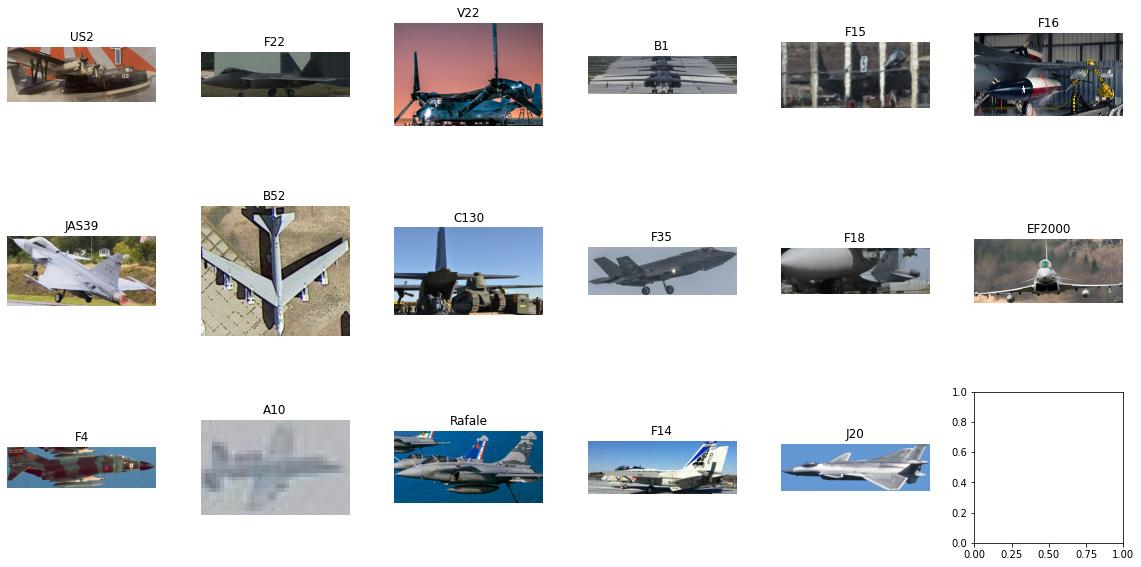

In [24]:
parent_path = '/content/Aircfraft_new/crop'

# Get a list of subdirectories in the directory
subdirectories = [f.path for f in os.scandir(parent_path) if f.is_dir()]

# Set up the plot
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(20, 10))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Loop through each subdirectory
for i, subdirectory in enumerate(subdirectories):
    # Get the label (the name of the subdirectory)
    label = os.path.basename(subdirectory)
    
    # Get a list of image files in the subdirectory
    image_files = [f for f in os.listdir(subdirectory) if f.endswith('.jpg')]
    
    # If there is at least one image file, display the first image
    if image_files:
        image_path = os.path.join(subdirectory, image_files[0])
        image = Image.open(image_path)
        ax = axes[i // 6, i % 6]
        ax.imshow(image)
        ax.set_title(label)
        ax.axis('off')

# Show the plot
plt.show()

Define a Function to find the max value for heigth and width of an image in our dataset

In [25]:
def find_max_size(path, folder_name):
  max_h = 0
  max_w = 0
  for subfolder in folder_name:
    
    subfolder_path = os.path.join(parent_path, subfolder)

    for file in os.listdir(subfolder_path):
      file_path = os.path.join(subfolder_path, file)

      with Image.open(file_path) as img:
        w = img.size[0]
        h = img.size[1]

      if h >= max_h:
        max_h = h
        max_h_img = file_path

      if w >= max_w:
        max_w = w
        max_w_img = file_path
  
  return max_h_img, max_w_img

In [26]:
parent_path = '/content/Aircfraft_new/crop'
folder_name

big_h_img, big_w_img = find_max_size(parent_path, folder_name)

image with highest value in Width

(7359, 4911)


<function matplotlib.pyplot.show(close=None, block=None)>

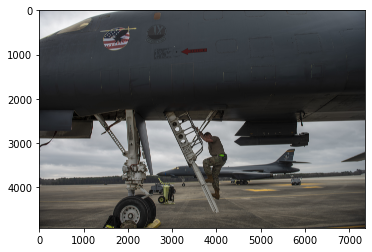

In [27]:
image = Image.open(big_w_img)

print(image.size)

plt.imshow(image)
plt.show

image with highest value in heigth

(7359, 4911)


<function matplotlib.pyplot.show(close=None, block=None)>

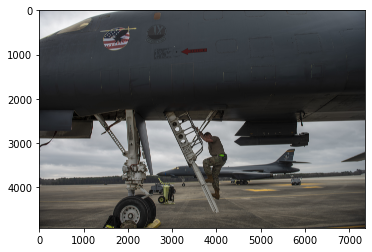

In [28]:
image = Image.open(big_h_img)

print(image.size)

plt.imshow(image)
plt.show

Create a Dataframe to show up:

- mean value of Height and Width for each class
- number of images which are particularly small or significantly high

In [29]:
parent_path = '/content/Aircfraft_new/crop'

folder_name

heigth_list =[]
width_list = []
count_list50 = []
count_list70 = []
count_list1000 = []
count_list4000 = []

for subfolder in folder_name:
  heigth = []
  width = []
  count50 = 0
  count70 = 0
  count1000 = 0
  count4000 = 0

  # Get a list of all files in the subfolder
  subfolder_path = os.path.join(parent_path, subfolder)
  
  # Loop through each file in the subfolder
  for file in os.listdir(subfolder_path):
    file_path = os.path.join(subfolder_path, file)

    with Image.open(file_path) as img:
      w = img.size[0]
      h = img.size[1]

    if h < 50 and w < 50:
      count50 += 1

    if h < 70 and w < 70:
      count70 += 1
    
    if h > 1000 and w > 1000:
      count1000 += 1
    
    if h > 4000 or w > 4000:
      count4000 += 1

    heigth.append(h)
    width.append(w)
    
  heigth_list.append(round(np.mean(heigth), 2))
  width_list.append(round(np.mean(width), 2))
  count_list50.append(count50)
  count_list70.append(count70)
  count_list1000.append(count1000)
  count_list4000.append(count4000)

In [30]:
df.insert(2, 'Heigth Mean', heigth_list)
df.insert(3, 'Width Mean', width_list)
df.insert(4, '<70pp', count_list70)
df.insert(5, '<50pp', count_list50)
df.insert(6, '>1000pp', count_list1000)
df.insert(7, '>4000pp', count_list4000)

df

,file,N_img,Heigth Mean,Width Mean,<70pp,<50pp,>1000pp,>4000pp
0,US2,350,201.84,495.41,25,12,4,1
1,F22,350,321.36,605.10,16,9,17,4
2,V22,350,276.70,566.05,52,32,18,3
3,B1,350,396.63,1030.13,15,6,33,16
4,F15,350,278.80,534.04,28,16,12,1
5,F16,350,385.51,668.87,24,14,27,5
6,JAS39,350,307.81,589.66,12,9,6,2
7,B52,350,244.62,593.92,17,7,12,2
8,C130,350,324.86,724.22,10,5,20,3
9,F35,350,311.86,595.36,16,2,15,1


## create a Crop_test folder with 20% of Crop images

Now We do random undersamplig using OS to make the classes uniform.

Then We create the Valid Folder as a copy of crop folder

In [31]:
!cp -r crop crop_valid.copy

rename crop_valid_copy as crop_valid

In [32]:
!mv crop_valid.copy crop_valid

Since the copy of the folders lead to the duolication of the images, we delate all the duplicated images in crop_valid folder in order to correctly divide the dataset in train and valid

In [33]:
# Set the path to the folder containing the subfolders with images
parent_path = '/content/Aircfraft_new/crop_valid'

# Get a list of all subfolders in the parent folder
subfolders = [f.path for f in os.scandir(parent_path) if f.is_dir()]

# Loop through each subfolder and delete all images
for subfolder_path in subfolders:
    # Get a list of all files in the subfolder
    files = os.listdir(subfolder_path)
    
    # Loop through each file in the subfolder
    for file in files:
        file_path = os.path.join(subfolder_path, file)
        
        # Check if the file is an image
        try:
            img = Image.open(file_path)
        except:
            continue
        
        # If the file is an image, delete it
        os.remove(file_path)

Now we create the Test folder, which will contain a 6% of the Validation Folder, to test the actual predictive power of the model

In [34]:
!cp -r crop_valid crop_test.copy

In [35]:
!mv crop_test.copy crop_test

Crop_valid

In [36]:
# Set the path to the folder containing the subfolders with images
data_folder = "/content/Aircfraft_new"

# Set the path to the folder where the train and test data will be stored
train_folder = "/content/Aircfraft_new/crop"
valid_folder = "/content/Aircfraft_new/crop_valid" #val folder 

# Set the test data ratio (i.e., the proportion of data that will be used for testing)
valid_ratio = 0.2 #val ratio 

# Loop through each subfolder in the data folder
for subfolder_name in os.listdir(train_folder):
    subfolder_path = os.path.join(train_folder, subfolder_name)
    if not os.path.isdir(subfolder_path):
        continue
    
    # Get a list of all image files in the subfolder
    image_files = [subfolder_path+'/' + str(f) for f in os.listdir(subfolder_path) if f.endswith('.jpg')]

    # Use train_test_split to split the image files into train and test sets
    train_files, valid_files = train_test_split(image_files, test_size=valid_ratio, random_state=42)

    # Move the train and test image files to the respective subfolders
    valid_subfolder_path = os.path.join(valid_folder, subfolder_name)

    for valid_file in valid_files:
        src_path = valid_file
        valid_file = valid_file.replace('crop','crop_valid')
        dst_path = valid_file
        shutil.move(src_path, dst_path)

In [37]:
b = len(os.listdir(train_folder + '/' + 'A10')); b

280

In [38]:
a = len(os.listdir(valid_folder + '/' + 'A10')); a

70

Crop_Test

In [39]:
data_folder = "/content/Aircfraft_new"

# Set the path to the folder where the train and test data will be stored
valid_folder = "/content/Aircfraft_new/crop_valid"
test_folder = "/content/Aircfraft_new/crop_test" #val folder 

# Set the test data ratio (i.e., the proportion of data that will be used for testing)
test_ratio = 0.06 #val ratio 

# Loop through each subfolder in the data folder
for subfolder_name in os.listdir(valid_folder):
    subfolder_path = os.path.join(valid_folder, subfolder_name)
    if not os.path.isdir(subfolder_path):
        continue
    
    # Get a list of all image files in the subfolder
    image_files = [subfolder_path+'/' + str(f) for f in os.listdir(subfolder_path) if f.endswith('.jpg')]

    # Use train_test_split to split the image files into train and test sets
    valid_files, test_files = train_test_split(image_files, test_size=test_ratio, random_state=42)

    # Move the train and test image files to the respective subfolders
    test_subfolder_path = os.path.join(test_folder, subfolder_name)

    for test_file in test_files:
        src_path = test_file
        test_file = test_file.replace('crop_valid','crop_test')
        dst_path = test_file
        shutil.move(src_path, dst_path)

In [40]:
c = len(os.listdir(test_folder + '/' + 'A10')); c

5

# batch_size

In [41]:
batch_size = 16

# train_dataset & train_dataloader

Now We are goinge to create and implement the object Dataloader for Train, Validation and Test. In order to do so We resize all the images to 224x224 pixels. 

In [42]:
# Set the path to the train folder containing subfolders for each class
train_folder = "/content/Aircfraft_new/crop"

# Define the image transforms to be applied to the images
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 pixels
    transforms.ToTensor(),  # Convert the images to PyTorch tensors
])

# Create a dataset from the train folder using the ImageFolder class
train_dataset = ImageFolder(train_folder, transform=image_transforms)

train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [43]:
X = next(iter(train_dataloader))

In [44]:
X[0].shape

torch.Size([16, 3, 224, 224])

In [45]:
train_dataloader

# valid_dataset & valid_dataloader

In [46]:
valid_folder = "/content/Aircfraft_new/crop_valid"

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  
])

valid_dataset = ImageFolder(valid_folder, transform=image_transforms)
valid_dataloader = data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [47]:
Z = next(iter(valid_dataloader))

In [48]:
Z[0].shape

torch.Size([16, 3, 224, 224])

In [49]:
valid_dataloader

# test_dataset & test_dataloader

In [50]:
test_folder = "/content/Aircfraft_new/crop_test"

image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()   
])


test_dataset = ImageFolder(test_folder, transform=image_transforms)
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [51]:
Q = next(iter(test_dataloader))

The Test dataloader will have **batch_size = 1**, since it will be used to see the models' predictive power. 

In [52]:
Q[0].shape

torch.Size([1, 3, 224, 224])

In [53]:
test_dataloader

# Train Function

Now we define the Train function which We will use to see our models' behavior, in terms of Train/Valid Accuracy and Train loss.

In [54]:
def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

def train(net, train_iter, test_iter, num_epochs, lr, device=d2l.try_gpu()):
    """Train a model with a GPU"""
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight) # Xavier parameter initialization: a particular method (see textbook section)
    net.apply(init_weights)
    print('training on', device)

    net.to(device) # MOVE the net to the GPU (if available)
    #optimizer = torch.optim.SDG(net.parameters(), lr=lr)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'valid acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = d2l.Accumulator(3)
        net.train() # Set the network to training mode (not evaluation mode)

        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device) #MOVE each minibatch of data to the GPU (if available)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad(): # detach gradient calculation for avoiding effect on backpropagation calculation
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'valid acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')

# Confusion Matrix

In [55]:
def evaluate_and_print_confusion_matrix(net, data_iter, classes, device=None):
    """Compute the confusion matrix for a model on a dataset using a GPU and print it"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    y_true = []
    y_pred = []
    for X, y in data_iter:
        if isinstance(X, list):
            # Required if doing the fine-tuning of BERT (recurrent network)
            X = [x.to(device) for x in X]
        else:
            X = X.to(device)
        y = y.to(device)
        outputs = net(X)
        _, predicted = torch.max(outputs, 1)
        y_true += y.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

    # Compute the evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Print the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    # Plot the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()

    return y_true,y_pred

# Data Augmentation

We perform two different kinds of Data Augmentation on our images, considering the format of the pictures and their characteristics.

All the Augmenation we perform are aimed to increase the training sample size, to reduce the possibile overfitting and to introduce more "*noise*" in the dataset.

In [56]:
train_folder = "/content/Aircfraft_new/crop"

Firstly we implement a **Structural Augmentation**, which will Flip Vertically all the images; then we apply randomly a distortion in perspective and an ereasing on all the RGB levels, to increaase the noise in the image.

In [57]:
struct_aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.RandomVerticalFlip(p=1),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), value='random'),
    transforms.Resize((224,224)),
    ])

Then we apply a **Color Augmentation**; these kind of modification will change the brightness and the sharpness of the image, making dark or contrasted images more readable; after that we apply a random color inversion, to obtain a kind of Negative Image.

In [58]:
color_aug = transforms.Compose([
  transforms.ToTensor(),
  transforms.ColorJitter(brightness=0.25, contrast=0, saturation=0, hue=0.3),
  transforms.RandomInvert(p=0.5),
  transforms.RandomAdjustSharpness(sharpness_factor=2, p=1),
  transforms.Resize((224,224)),
  ])

To have an idea of these modification, we show an image with the Augmentation applied

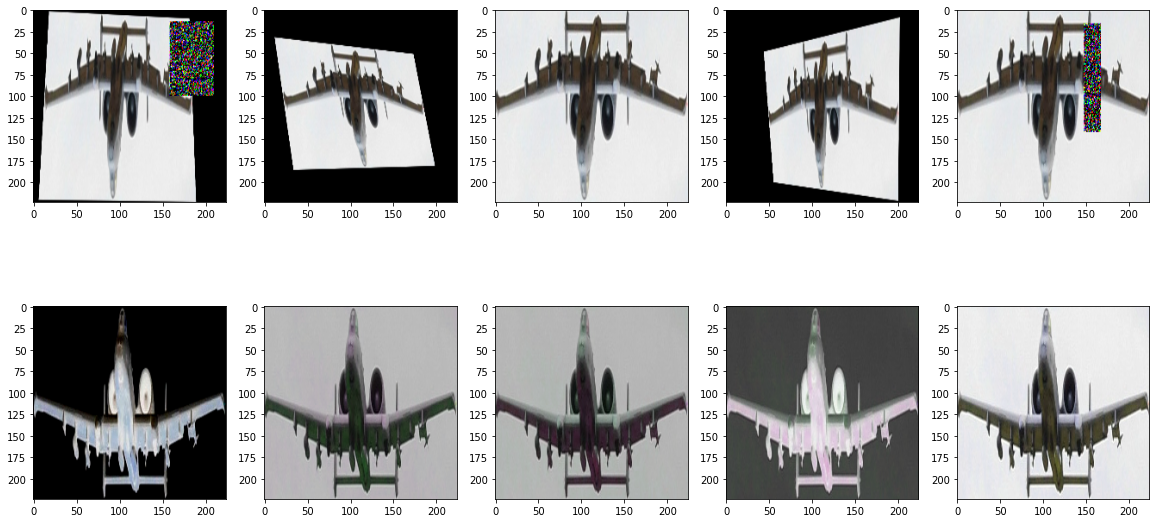

In [59]:
image_path = '/content/Aircfraft_new/crop/A10/01ed4d81c5d733cbaa266b6ea7821254_0.jpg'

aug_list = [struct_aug, color_aug]

img = Image.open(image_path)

fig, axs = plt.subplots(2, 5, figsize=(20, 10))

for k in range(2):
  for i in range(5):
    row = k
    col = i
    img = Image.open(image_path)
    img_transformed = aug_list[k](img)
    axs[row][col].imshow(img_transformed.permute(1, 2, 0))

Since we wanted to increase the sample size of the train dataset, we applied the Augmentation individually on train, creating 3 different Train datasets: 1 without augmentation, 1 with the structural and 1 with color modification, then we concatenate them to botain only one Dataloader object

In [60]:
# create the final joined dataset
l= [] #empty list

# append to the list folders with respective transformations
l.append(datasets.ImageFolder(root = train_folder, transform = struct_aug))
l.append(datasets.ImageFolder(root = train_folder, transform = color_aug))

l.append(datasets.ImageFolder(root = train_folder, transform = image_transforms))

# concatenate the dataset
aug_train_dataset = torch.utils.data.ConcatDataset(l)

# AlexNet

Starting from the Standarrd AlexNet architecture and after several attempts, we understand that the best solution could be the one with kernel size reduction. 

Traditionally the reduction of the Kernel leads to a problem of overfitting, but in our case it leads to better performances and results. We have indeed images with different dimensions, including very small ones.

Following the same reasoning, we reduced the stride parameter, which decides how many pixels to move the kernel window. By reducing it, the model has more cycles to read the image; of course this procedure lead us to increase the number of Dropout layers to contain the risk of general overfitting.

In [64]:
net = nn.Sequential(
    
    nn.Conv2d(3, batch_size, kernel_size=5, stride=2, padding=1),
    nn.ReLU(inplace = True),
    
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(batch_size, 192, kernel_size=5, padding=2), 
    nn.ReLU(inplace = True), 
    nn.MaxPool2d(kernel_size=3, stride=2),
    
    nn.Conv2d(192, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace = True),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), 
    nn.ReLU(inplace = True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), 
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    
    nn.Dropout(p=0.5),
    nn.Linear(43264, 4096), 
    nn.ReLU(inplace = True),

    nn.Dropout(p=0.4),
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace = True), 
    nn.Dropout(p=0.2),

    nn.Linear(4096, 17)
) 

In [62]:
X = torch.randn(batch_size, 3, 224, 224)

for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([16, 16, 111, 111])
ReLU Output shape:	 torch.Size([16, 16, 111, 111])
MaxPool2d Output shape:	 torch.Size([16, 16, 55, 55])
Conv2d Output shape:	 torch.Size([16, 192, 55, 55])
ReLU Output shape:	 torch.Size([16, 192, 55, 55])
MaxPool2d Output shape:	 torch.Size([16, 192, 27, 27])
Conv2d Output shape:	 torch.Size([16, 384, 27, 27])
ReLU Output shape:	 torch.Size([16, 384, 27, 27])
Conv2d Output shape:	 torch.Size([16, 384, 27, 27])
ReLU Output shape:	 torch.Size([16, 384, 27, 27])
Conv2d Output shape:	 torch.Size([16, 256, 27, 27])
ReLU Output shape:	 torch.Size([16, 256, 27, 27])
AvgPool2d Output shape:	 torch.Size([16, 256, 13, 13])
Flatten Output shape:	 torch.Size([16, 43264])
Dropout Output shape:	 torch.Size([16, 43264])
Linear Output shape:	 torch.Size([16, 4096])
ReLU Output shape:	 torch.Size([16, 4096])
Dropout Output shape:	 torch.Size([16, 4096])
Linear Output shape:	 torch.Size([16, 4096])
ReLU Output shape:	 torch.Size([16, 4096])
Dropout 

loss 0.079, train acc 0.980, valid acc 0.535
136.7 examples/sec on cuda:0


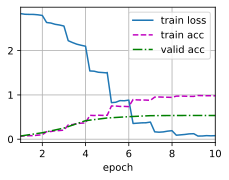

In [65]:
lr, num_epochs = 7e-5, 10
train(net, train_dataloader, valid_dataloader, num_epochs, lr, device=d2l.try_gpu())

From the above plot we can see that the validation accuracy is quite good, almost 54%. Despite the additional Dropout layers, we stile have a significant overfitting.

## Save&Load the model weigth to perform the Test

To be able to perform the Test on new unseen images, we save the model's weigths obtained by the training phase

In [66]:
torch.save(net.state_dict(), '/content/drive/MyDrive/DEEP_LEARNING/AlexNet.pth')

Then we load them in a new model not pre-trained and give it the images in a single batch

In [67]:
# Recall the model
model_weigth_path = '/content/drive/MyDrive/DEEP_LEARNING/AlexNet.pth'

# Load the saved state dictionary into the model
net.load_state_dict(torch.load(model_weigth_path))

<All keys matched successfully>

From this procedure we can have a estimate on the ability of the model to generalize based on the data provided

Accuracy: 0.4706
Precision: 0.5703
Recall: 0.4706
F1-score: 0.4626


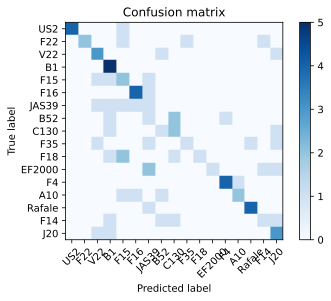

In [69]:
y_true, y_pred = evaluate_and_print_confusion_matrix(net, test_dataloader, folder_name, device=None)

From the Confusion Matrix we can see that our model is able to predict well 6/7 classes. This result is probably due to the low resolution of images and to the similaity between some aircraft types.

### Display images predicted wrong

In [70]:
root_testing = '/content/Aircfraft_new/crop_test'
flowers_dirs = os.listdir(root_testing)

In [71]:
classes = [cla for cla in os.listdir(root_testing) if os.path.isdir(os.path.join(root_testing, cla))]
class_indices = {k: v for v, k in enumerate(classes)}

In [72]:
json_str = json.dumps({v: k for k, v in class_indices.items()}, indent=4)
with open('classes_indices_training.json', 'w') as json_file:
    json_file.write(json_str)

In [73]:
every_class_num_test = []
supported = ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']

# Lists containg information of paths, labels and bad images for Testing
filepaths_test = []
labels_test = []
bad_images_test = []
for klass in classes:
  classpath = os.path.join(root_testing, klass)
  images = [os.path.join(root_testing, klass, i) for i in os.listdir(classpath) if os.path.splitext(i)[-1] == supported]
  every_class_num_test.append(len(images))
  flist = sorted(os.listdir(classpath))
  desc = f'{klass:23s}'
  for f in tqdm(flist, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(classpath, f)
      fl = f.lower()
      index = fl.rfind('.')
      ext = fl[index:]
      if ext in supported:
          image = Image.open(fpath)
          if image.mode == 'RGB':
              try:
                  img = cv2.imread(fpath)
                  filepaths_test.append(fpath)
                  labels_test.append(klass)
              except:
                  bad_images_test.append(fpath)
                  print('defective image file: ', fpath)
      else:
          bad_images_test.append(fpath)

J20                    : 100%|███████████████████████████████████████████████| 5/5 [00:00<00:00, 956.38file/s]


In [74]:
Fseries = pd.Series(filepaths_test, name='filepaths')
Lseries = pd.Series(labels_test, name='labels')
df_test = pd.concat([Fseries, Lseries], axis=1)
print(f'{len(df_test.labels.unique())} kind of images were found in the dataset')

17 kind of images were found in the dataset


In [75]:
test_image_path = df_test['filepaths'].tolist()
test_image_label = [class_indices[i] for i in df_test['labels'].tolist()] 

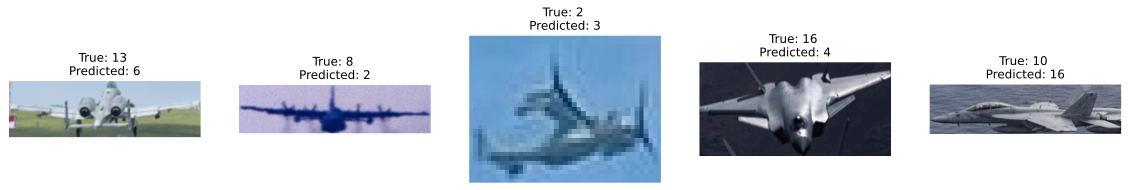

In [76]:
# convert the lists to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# find the indices of incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# select a few of these images to display
num_images_to_display = 5
selected_indices = np.random.choice(incorrect_indices, num_images_to_display, replace=False)

# display the selected images
plt.figure(figsize=(20,10))

for i, index in enumerate(selected_indices):
    img = Image.open(test_image_path[index])
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.title("True: %s \nPredicted: %s" % (test_image_label[index], y_pred[index]))
    plt.axis('off')

plt.show()

Here we can see some of the 'wrongly predicted' images. As we said before the main reasons that lead the model to mis predict the images are:
- **low resolution** 
- **low light level**
- **different perspective**

# AlexNet w/ Augmented Data

In order to avoid/minimize the overfitting and increase the accuracy, we try to implement AlexNet with the Augmented Data.

In [77]:
batch_size_aug = 32 #with 64 doesn't change very much, so we decide to keep 32 even with augmented data
aug_train_dataloader = data.DataLoader(aug_train_dataset, batch_size=batch_size_aug, shuffle=True)
aug_valid_dataloader = data.DataLoader(valid_dataset, batch_size=batch_size_aug, shuffle=True)

In [79]:
net_aug = nn.Sequential(

    nn.Conv2d(3, batch_size_aug, kernel_size=7, stride=3, padding=1),
    nn.ReLU(inplace = True),

    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(batch_size_aug, 192, kernel_size=5, padding=2), 
    nn.ReLU(inplace = True), 
    nn.MaxPool2d(kernel_size=3, stride=2),

    nn.Conv2d(192, 384, kernel_size=3, padding=1),
    nn.ReLU(inplace = True),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), 
    nn.ReLU(inplace = True),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), 
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),

    nn.Dropout(p=0.5),
    nn.Linear(16384, 4096), 
    nn.ReLU(inplace = True),

    nn.Dropout(p=0.4),
    nn.Linear(4096, 4096), 
    nn.ReLU(inplace = True), 
    nn.Dropout(p=0.2),

    nn.Linear(4096, 17)
) 

In [80]:
X = torch.randn(batch_size_aug, 3, 224, 224)

for layer in net_aug:
    X = layer(X)
    print(layer.__class__.__name__,'Output shape:\t',X.shape)

Conv2d Output shape:	 torch.Size([32, 32, 74, 74])
ReLU Output shape:	 torch.Size([32, 32, 74, 74])
MaxPool2d Output shape:	 torch.Size([32, 32, 36, 36])
Conv2d Output shape:	 torch.Size([32, 192, 36, 36])
ReLU Output shape:	 torch.Size([32, 192, 36, 36])
MaxPool2d Output shape:	 torch.Size([32, 192, 17, 17])
Conv2d Output shape:	 torch.Size([32, 384, 17, 17])
ReLU Output shape:	 torch.Size([32, 384, 17, 17])
Conv2d Output shape:	 torch.Size([32, 384, 17, 17])
ReLU Output shape:	 torch.Size([32, 384, 17, 17])
Conv2d Output shape:	 torch.Size([32, 256, 17, 17])
ReLU Output shape:	 torch.Size([32, 256, 17, 17])
MaxPool2d Output shape:	 torch.Size([32, 256, 8, 8])
Flatten Output shape:	 torch.Size([32, 16384])
Dropout Output shape:	 torch.Size([32, 16384])
Linear Output shape:	 torch.Size([32, 4096])
ReLU Output shape:	 torch.Size([32, 4096])
Dropout Output shape:	 torch.Size([32, 4096])
Linear Output shape:	 torch.Size([32, 4096])
ReLU Output shape:	 torch.Size([32, 4096])
Dropout Output

loss 0.801, train acc 0.760, valid acc 0.542
359.3 examples/sec on cuda:0


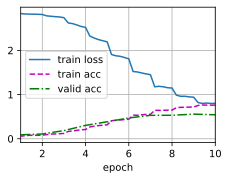

In [81]:
lr, num_epochs = 7e-5, 10
train(net_aug, aug_train_dataloader, aug_valid_dataloader, num_epochs, lr, device=d2l.try_gpu())

From the above plot we can see that the validation accuracy hasn't improved but we have reduced the overfitting.

In [82]:
torch.save(net_aug.state_dict(), '/content/drive/MyDrive/DEEP_LEARNING/AlexNet_Aug.pth')

## Test & Confusion Matrix

In [83]:
# Recall the model
model_weigth_path = '/content/drive/MyDrive/DEEP_LEARNING/AlexNet_Aug.pth'

# Load the saved state dictionary into the model
net_aug.load_state_dict(torch.load(model_weigth_path))

<All keys matched successfully>

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.4824
Precision: 0.4620
Recall: 0.4824
F1-score: 0.4395


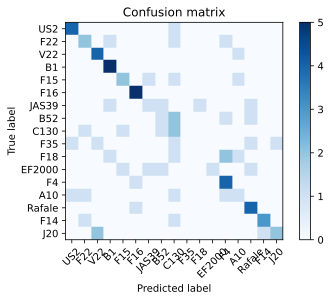

In [85]:
y_true, y_pred = evaluate_and_print_confusion_matrix(net_aug, test_dataloader, folder_name, device=None)

The Confusion Matrix seems to be sligthly better, but as before some classes are confused, despite the data augmentation. This leads us to think that some aircrafts types have features which are difficult to recognize. Given this constraint low image resolution doesn't help.

### Display images wrongly predicted

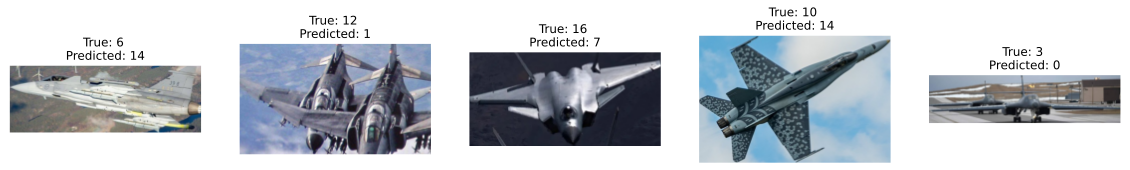

In [106]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# find the indices of incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# select a few of these images to display
num_images_to_display = 5
selected_indices = np.random.choice(incorrect_indices, num_images_to_display, replace=False)

# display the selected images
plt.figure(figsize=(20,10))

for i, index in enumerate(selected_indices):
    img = Image.open(test_image_path[index])
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.title("True: %s \nPredicted: %s" % (test_image_label[index], y_pred[index]))
    plt.axis('off')

plt.show()

# GoogleNet

After AlexNet, we decided to implement a more **deep** Neural Network Architecture: **GoogleNet**

Googlenet is a convolutional naural network based on the *Inception module*, This kind of architecture permitts a better resource usage and better performances. The architecture of the *Inception* module consists of multiple convolutions with different filter sizes and pooling operations in parallel.
To use of this architecture we first construct the Inception module class and then define the individual layers with all the parameters.


In [86]:
class Inception(nn.Module): 
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs): 
        super(Inception, self).__init__(**kwargs) 
 
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1) 
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))

        return torch.cat((p1, p2, p3, p4), dim=1)        

## layers

In [107]:
goog_batch_size = 64

In [108]:
goog_train_dataloader = data.DataLoader(train_dataset, batch_size=goog_batch_size, shuffle=True)

In [109]:
goog_valid_dataloader = data.DataLoader(valid_dataset, batch_size=goog_batch_size, shuffle=True)

In [90]:
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [91]:
b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.BatchNorm2d(64),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.BatchNorm2d(192),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [92]:
b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [93]:
b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [94]:
b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)),
                   nn.Flatten())

goognet = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 17))

In [ ]:
X = torch.rand(size=(1, 3, 224, 224))
for layer in goognet:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 192, 28, 28])
Sequential output shape:	 torch.Size([1, 480, 14, 14])
Sequential output shape:	 torch.Size([1, 832, 7, 7])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 17])


loss 2.116, train acc 0.309, valid acc 0.228
272.7 examples/sec on cuda:0


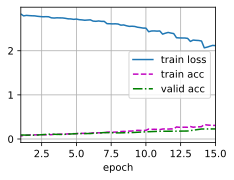

In [110]:
lr, num_epochs = 3e-4, 15
train(goognet, goog_train_dataloader, goog_valid_dataloader, num_epochs, lr, device=d2l.try_gpu())

As we can see from the result of the training phase, the accuracy is very laww and the time it needs lot of epochs to learn something from the images. Despite this result, its interesting see that it doesn't tend to overfit the data

In [111]:
torch.save(goognet.state_dict(), '/content/drive/MyDrive/DEEP_LEARNING/GoogleNet.pth')

## Test & Confusion Matrix

In [ ]:
# Recall the model
model_weigth_path = '/content/drive/MyDrive/DEEP_LEARNING/GoogleNet.pth'

# Load the saved state dictionary into the model
goognet.load_state_dict(torch.load(model_weigth_path))

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.2471
Precision: 0.2495
Recall: 0.2471
F1-score: 0.2045


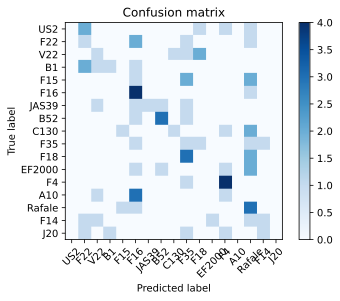

In [113]:
y_true, y_pred = evaluate_and_print_confusion_matrix(goognet, test_dataloader, folder_name, device=None)

As the result of the Training Phase suggested, this kind of architecture is doesn't perform very well on this set up. The Model can recognize pretty decently 5 classes, but tend to mis calssify in a strong way some of them.

This can lead us to the conclusion that maybe it is very slow to learn and if the data are not well distinguishable, it tends to strongly confuse them.

### Display images wrongly predicted

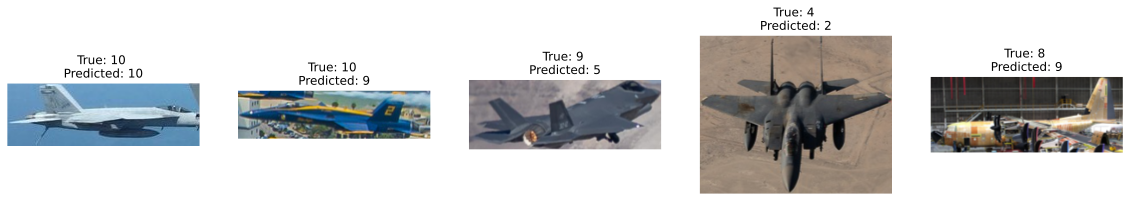

In [114]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# find the indices of incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# select a few of these images to display
num_images_to_display = 5
selected_indices = np.random.choice(incorrect_indices, num_images_to_display, replace=False)

# display the selected images
plt.figure(figsize=(20,10))

for i, index in enumerate(selected_indices):
    img = Image.open(test_image_path[index])
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.title("True: %s \nPredicted: %s" % (test_image_label[index], y_pred[index]))
    plt.axis('off')

plt.show()

# GoogleNet w/ Augmented Data

In [87]:
batch_size_goog_aug = 64

In [88]:
aug_train_dataloader_aug = data.DataLoader(aug_train_dataset, batch_size=batch_size_goog_aug, shuffle=True)
aug_valid_dataloader_aug = data.DataLoader(valid_dataset, batch_size=batch_size_goog_aug, shuffle=True)

loss 1.846, train acc 0.407, valid acc 0.386
233.4 examples/sec on cuda:0


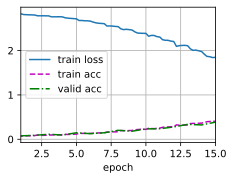

In [96]:
lr, num_epochs = 3e-4, 15
train(goognet, aug_train_dataloader_aug, aug_valid_dataloader_aug, num_epochs, lr, device=d2l.try_gpu())

As we have seen from the non-augmented GoogleNet, the model tends to learn very slowly from the images, but the use of a bigger and more noisy dataset permitted us to slightly increase the accuracy.

This result suggest us that this kind of Architecture needs an higher number of epochs and a bigger training dataset

In [100]:
torch.save(goognet.state_dict(), '/content/drive/MyDrive/DEEP_LEARNING/GoogleNet_aug1.pth')

## Test & Confusion Matrix

In [101]:
# Recall the model
model_weigth_path = '/content/drive/MyDrive/DEEP_LEARNING/GoogleNet_aug1.pth'

# Load the saved state dictionary into the model
goognet.load_state_dict(torch.load(model_weigth_path))

<All keys matched successfully>

Accuracy: 0.4235
Precision: 0.5069
Recall: 0.4235
F1-score: 0.4192


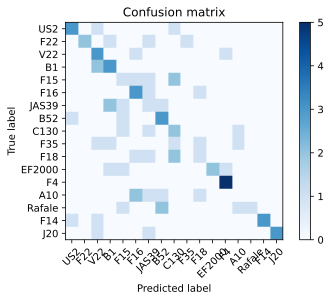

In [102]:
y_true, y_pred = evaluate_and_print_confusion_matrix(goognet, test_dataloader, folder_name, device=None)

From the result above, we can see that the accuracy has not significantly increased and that the problem in recogniseing images remains. We obtain some good results, despite of some other classes not been distinguished at all.

### Display images wrongly predicted

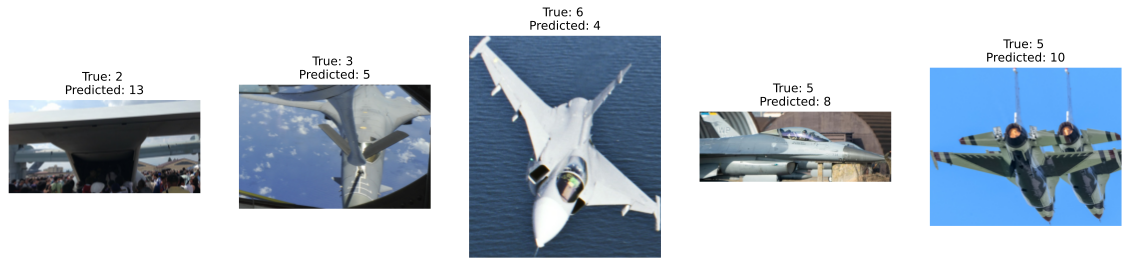

In [103]:
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# find the indices of incorrectly classified images
incorrect_indices = np.nonzero(y_pred != y_true)[0]

# select a few of these images to display
num_images_to_display = 5
selected_indices = np.random.choice(incorrect_indices, num_images_to_display, replace=False)

# display the selected images
plt.figure(figsize=(20,10))

for i, index in enumerate(selected_indices):
    img = Image.open(test_image_path[index])
    plt.subplot(1, num_images_to_display, i+1)
    plt.imshow(img)
    plt.title("True: %s \nPredicted: %s" % (test_image_label[index], y_pred[index]))
    plt.axis('off')

plt.show()

# Conclusions

From the results obtained, we can state that AlexNet is the best model when trained with more images (using Augmentation) for two main reasons:

* **Resource Limits**: both in term of hardware, time and images
* **Simplier**: for the same reason above, having a simplier architecture, permitts us to make more modification in order to better customize it to the data avialable. Things that is more difficult with deeper models as GoogleNet.


